### aim: calculate vertical gradients in c14


some old useful things could be in /gpfs/home/mep22dku/scratch/SOZONE/C14/make_verticalgradient.ipynb

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

great to hear you have solved the 1985 problem. Arg indeed for the make_c14gradient_one.jnl, it is in the folder here: /gpfs/home/e415/scratch/c14 (and pasted below for convenience)



        let c14 = if c14b lt 1e10 then c14b ! remove continents 

        let c14so = c14[j=2:47@ave,i=2:181@ave] 

        let dc14dz = c14so[k=17] - c14so[k=1] ! z=217m minus z=5m 



        let ccc = if dic lt 1e10 then dic ! remove continents 

        let dicso = ccc[j=2:47@ave,i=2:181@ave] 

        let ddicdz = dicso[k=17] - dicso[k=1] ! z=217m minus z=5m 



        !list/file=dc14dz.txt/append/noh/format=(f12.3) dc14dz 

        !save/file=dc14dz.nc/append dc14dz 

        save/file=dc14dz.nc/append ddicdz 

        can data/all 

 

## look at corinne's vertical gradient 

Text(0.5, 1.0, 'bomb c14 gradient in CLQ run')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


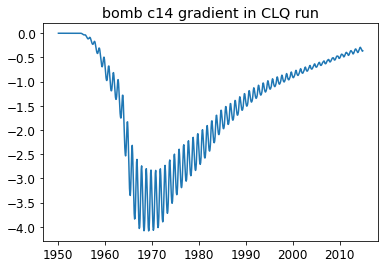

In [4]:
dc14dzf = './corinneData/dc14dz.nc'
CLQ_dc14dz  = xr.open_dataset(dc14dzf)
times = pd.date_range("1950/01/01","2014/12/01",freq='MS')
CLQ_dc14dz['TIME_COUNTER'] = times

plt.plot(CLQ_dc14dz.TIME_COUNTER,CLQ_dc14dz.DC14DZ)
plt.title('bomb c14 gradient in CLQ run')

In [11]:

extract = False

if extract:
    
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    tmask = tmesh.tmask[0,0,:,:] 
    area_surface = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    area_16 = tmesh.tmask[0,16,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    yrst = 1940; yrend = 2024
    tr = 'GEC4'
    trs = ['GEA4','GEC4','C405', 'C4C5']
    for tr in trs:
        for yr in range(yrst,yrend):

            baseDir = '/gpfs/data/greenocean/software/runs/'
            dtype = 'ptrc'
            ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yr}*{dtype}*.nc'
            
            try:
                t2 = glob.glob(ty)
                w = xr.open_dataset(t2[0])
                DIC_L17 = w.DIC.isel(deptht = 16).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DIC_L1 = w.DIC.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DDICDZ = DIC_L17-DIC_L1
                
                B14B_L17 = w.B14B.isel(deptht = 16).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                B14B_L1 = w.B14B.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DB14DZ = B14B_L17-B14B_L1 
                
                C14B_L17 = w.C14B.isel(deptht = 16).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                C14B_L1 = w.C14B.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DC14DZ = C14B_L17-C14B_L1 
                
                
                print(f'{tr} {yr}: B14-grad {np.nanmean(DB14DZ)}, C14-grad {np.nanmean(DC14DZ)} DIC-grad {np.nanmean(DDICDZ)}')



                savenam = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{tr}_dc14dz_y{yr}.nc'
                data_vars = {'DC14DZ':(['time_counter'], DC14DZ.values,
                {'units': '',
                'long_name':'DC14DZ (lev16-lev0, y = slice(0,47), mean, python indexing)'}),

                 'DDICDZ':(['time_counter'], DDICDZ.values,
                {'units': '',
                'long_name':'DDICDZ (lev16-lev0, y = slice(0,47), mean, python indexing)'}),            
                
                'DB14DZ':(['time_counter'], DB14DZ.values,
                {'units': '',
                'long_name':'DB14DZ (lev16-lev0, y = slice(0,47), mean, python indexing)'}),

                }
                # define coordinates
                coords = {'time_counter': (['time_counter'], DC14DZ.time_counter),

                }
                # define global attributes
                attrs = {'made in':'SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb',
                'desc': 'yearly medusa files, saving only variables of interest'
                }
                ds = xr.Dataset(data_vars=data_vars,
                coords=coords,
                attrs=attrs)

                ds
                ds.to_netcdf(savenam)
                
            except:
                
                print(f'NO FILE MADE FOR {tr} -- {yr}')
    
# tin

GEA4 1940: B14-grad -1.4013877800599317, C14-grad -1.2882504350759543 DIC-grad 5.624662108392723e-05
NO FILE MADE FOR GEA4 -- 1940


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1941: B14-grad -1.2386551082364372, C14-grad -1.135292295440979 DIC-grad 4.3154481479157434e-05
NO FILE MADE FOR GEA4 -- 1941


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1942: B14-grad -1.0618559193531607, C14-grad -0.9754079729843923 DIC-grad 3.10127048558558e-05
GEA4 1943: B14-grad -1.0784705096883187, C14-grad -0.986270145917175 DIC-grad 3.454749234359692e-05
NO FILE MADE FOR GEA4 -- 1943


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1944: B14-grad -1.1082008502839018, C14-grad -1.0086731001971752 DIC-grad 3.541356937699562e-05
NO FILE MADE FOR GEA4 -- 1944


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1945: B14-grad -1.1601581934177068, C14-grad -1.051043420605918 DIC-grad 3.671477562443271e-05
GEA4 1946: B14-grad -1.1821029495667168, C14-grad -1.0652706785670716 DIC-grad 3.739859914522317e-05
NO FILE MADE FOR GEA4 -- 1946


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1947: B14-grad -1.182766529170079, C14-grad -1.057617074263293 DIC-grad 3.789846269529947e-05
GEA4 1948: B14-grad -1.205501251757778, C14-grad -1.0738635193276345 DIC-grad 3.891227656193614e-05
GEA4 1949: B14-grad -1.2255252063911215, C14-grad -1.088024312531914 DIC-grad 3.960077228263012e-05
GEA4 1950: B14-grad -1.2376361568232466, C14-grad -1.0943822502496594 DIC-grad 3.933695825248664e-05
NO FILE MADE FOR GEA4 -- 1950


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1951: B14-grad -1.2414708495612838, C14-grad -1.0868026248545926 DIC-grad 4.031726490299306e-05
NO FILE MADE FOR GEA4 -- 1951


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1952: B14-grad -1.2530297837106046, C14-grad -1.0945985623111802 DIC-grad 3.996568265823237e-05
NO FILE MADE FOR GEA4 -- 1952


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1953: B14-grad -1.227652247064536, C14-grad -1.0693381499393 DIC-grad 3.96608086454084e-05
NO FILE MADE FOR GEA4 -- 1953


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1954: B14-grad -1.2189495559942891, C14-grad -1.0632970937991706 DIC-grad 3.913225176802377e-05
NO FILE MADE FOR GEA4 -- 1954


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1955: B14-grad -1.214216716739455, C14-grad -1.1530960831818466 DIC-grad 3.959562775561324e-05
GEA4 1956: B14-grad -1.2484602538858136, C14-grad -1.3408523452905161 DIC-grad 4.010167897539027e-05
NO FILE MADE FOR GEA4 -- 1956


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1957: B14-grad -1.269012534740722, C14-grad -1.5648641466667648 DIC-grad 4.048136351054557e-05
NO FILE MADE FOR GEA4 -- 1957


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1958: B14-grad -1.2956570468113526, C14-grad -1.9441549251282406 DIC-grad 4.093042501275792e-05
GEA4 1959: B14-grad -1.2750610791914136, C14-grad -2.3959748949907316 DIC-grad 4.014478631924343e-05
GEA4 1960: B14-grad -1.2656313109134825, C14-grad -2.8624754574486695 DIC-grad 3.995875048926501e-05
GEA4 1961: B14-grad -1.277427476974738, C14-grad -3.224562421014738 DIC-grad 4.042574429836347e-05
GEA4 1962: B14-grad -1.2525852332043057, C14-grad -3.4576403724219276 DIC-grad 3.8948580386186506e-05
NO FILE MADE FOR GEA4 -- 1962


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1963: B14-grad -1.237467150374268, C14-grad -4.026464878825537 DIC-grad 3.8358021661711325e-05
GEA4 1964: B14-grad -1.250027356675725, C14-grad -5.2100680878780095 DIC-grad 3.8020258800448166e-05
GEA4 1965: B14-grad -1.2706984246431556, C14-grad -6.294635622611781 DIC-grad 3.720738636439845e-05
NO FILE MADE FOR GEA4 -- 1965


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1966: B14-grad -1.269223511471579, C14-grad -7.003428914802902 DIC-grad 3.799214444840987e-05
NO FILE MADE FOR GEA4 -- 1966


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1967: B14-grad -1.2825190913594877, C14-grad -7.3113737258833 DIC-grad 3.8026555878482925e-05
NO FILE MADE FOR GEA4 -- 1967


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEA4 1968: B14-grad -1.2981953045508827, C14-grad -7.451904188793416 DIC-grad 3.8426914180418006e-05
GEA4 1969: B14-grad -1.3033786853082603, C14-grad -7.379738548077338 DIC-grad 3.8429633846545184e-05
GEA4 1970: B14-grad -1.2771113713648756, C14-grad -7.358446771971199 DIC-grad 3.77754550238938e-05
GEA4 1971: B14-grad -1.2582769663162727, C14-grad -6.984185246814605 DIC-grad 3.7179541891904935e-05
GEA4 1972: B14-grad -1.2836591643398723, C14-grad -6.807625319243158 DIC-grad 3.803889666194937e-05
GEA4 1973: B14-grad -1.2715773819557998, C14-grad -6.593260817148533 DIC-grad 3.722764647471244e-05
GEA4 1974: B14-grad -1.232844044479604, C14-grad -6.141916822021173 DIC-grad 3.6826233179680645e-05
GEA4 1975: B14-grad -1.2429632263985242, C14-grad -5.798588804037859 DIC-grad 3.6797403824564405e-05
GEA4 1976: B14-grad -1.2553438657018587, C14-grad -5.657027891723858 DIC-grad 3.636634138462419e-05
GEA4 1977: B14-grad -1.2924343105940173, C14-grad -5.57857856737587 DIC-grad 3.797040330834558e-0

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1941: B14-grad -1.3423081337525138, C14-grad -1.2203314388761373 DIC-grad 4.68509126336971e-05
NO FILE MADE FOR GEC4 -- 1941


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1942: B14-grad -1.1960897780381876, C14-grad -1.09385264624599 DIC-grad 3.4847443950000236e-05
NO FILE MADE FOR GEC4 -- 1942


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1943: B14-grad -1.2256229045461866, C14-grad -1.1143318916959515 DIC-grad 3.883997507892552e-05
NO FILE MADE FOR GEC4 -- 1943


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1944: B14-grad -1.264038173246445, C14-grad -1.1421496075144977 DIC-grad 4.0370832916977686e-05
NO FILE MADE FOR GEC4 -- 1944


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1945: B14-grad -1.2868688736734117, C14-grad -1.156089802592622 DIC-grad 4.110468719964376e-05
NO FILE MADE FOR GEC4 -- 1945

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file



GEC4 1946: B14-grad -1.2999075302344478, C14-grad -1.1617252029293061 DIC-grad 4.152656290119393e-05
NO FILE MADE FOR GEC4 -- 1946


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1947: B14-grad -1.307310969103263, C14-grad -1.1626964365952828 DIC-grad 4.169309568692191e-05
NO FILE MADE FOR GEC4 -- 1947


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1948: B14-grad -1.3113474154027227, C14-grad -1.160799972651834 DIC-grad 4.182092169552498e-05
NO FILE MADE FOR GEC4 -- 1948


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1949: B14-grad -1.3131706313029377, C14-grad -1.1570632491110906 DIC-grad 4.186908220460634e-05
NO FILE MADE FOR GEC4 -- 1949


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1950: B14-grad -1.3135210377568953, C14-grad -1.1521391029471837 DIC-grad 4.191125052496891e-05
NO FILE MADE FOR GEC4 -- 1950


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1951: B14-grad -1.3129521169438034, C14-grad -1.14647387260748 DIC-grad 4.1853283038233625e-05
NO FILE MADE FOR GEC4 -- 1951


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1952: B14-grad -1.3119452074160924, C14-grad -1.1404863050418224 DIC-grad 4.18549754471893e-05
NO FILE MADE FOR GEC4 -- 1952


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1953: B14-grad -1.3107396877530375, C14-grad -1.1343879597876565 DIC-grad 4.176012962191464e-05
NO FILE MADE FOR GEC4 -- 1953


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1954: B14-grad -1.3095194053597157, C14-grad -1.1337974011820988 DIC-grad 4.177003217908402e-05
NO FILE MADE FOR GEC4 -- 1954


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1955: B14-grad -1.3083066012233449, C14-grad -1.2363668790284719 DIC-grad 4.168128405531234e-05
NO FILE MADE FOR GEC4 -- 1955


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1956: B14-grad -1.3071080663833174, C14-grad -1.4082355310152759 DIC-grad 4.1637987271544216e-05
NO FILE MADE FOR GEC4 -- 1956


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1957: B14-grad -1.305930750822393, C14-grad -1.6231451393213117 DIC-grad 4.15316457882734e-05
NO FILE MADE FOR GEC4 -- 1957


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1958: B14-grad -1.3047377274483853, C14-grad -1.9713465179137604 DIC-grad 4.14771352633146e-05
NO FILE MADE FOR GEC4 -- 1958


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1959: B14-grad -1.3034924739200324, C14-grad -2.4523388521399485 DIC-grad 4.131268698895699e-05
NO FILE MADE FOR GEC4 -- 1959


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1960: B14-grad -1.302241867847169, C14-grad -2.9208918002153843 DIC-grad 4.117318023191208e-05


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


NO FILE MADE FOR GEC4 -- 1960
GEC4 1961: B14-grad -1.3009614612078209, C14-grad -3.241166622434518 DIC-grad 4.098714508374204e-05
NO FILE MADE FOR GEC4 -- 1961


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1962: B14-grad -1.2997156568438557, C14-grad -3.5326133419780175 DIC-grad 4.0824835208293e-05
NO FILE MADE FOR GEC4 -- 1962


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1963: B14-grad -1.2984807686293662, C14-grad -4.249715696725576 DIC-grad 4.061496781791968e-05
NO FILE MADE FOR GEC4 -- 1963


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1964: B14-grad -1.2972431903114128, C14-grad -5.623415865698392 DIC-grad 4.0453842875318234e-05
NO FILE MADE FOR GEC4 -- 1964


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1965: B14-grad -1.2960420104413737, C14-grad -6.935520010320869 DIC-grad 4.036900171985457e-05
NO FILE MADE FOR GEC4 -- 1965


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1966: B14-grad -1.2948424333361308, C14-grad -7.592344155101592 DIC-grad 4.031982955246173e-05
NO FILE MADE FOR GEC4 -- 1966


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1967: B14-grad -1.2936300941874501, C14-grad -7.743427059758133 DIC-grad 3.997437982340954e-05
NO FILE MADE FOR GEC4 -- 1967


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1968: B14-grad -1.2924045086972384, C14-grad -7.690322651260849 DIC-grad 3.979043422843285e-05
NO FILE MADE FOR GEC4 -- 1968


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1969: B14-grad -1.2911436929971225, C14-grad -7.6040632840729 DIC-grad 3.958552390749049e-05
NO FILE MADE FOR GEC4 -- 1969


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1970: B14-grad -1.2898797172927787, C14-grad -7.509580131442102 DIC-grad 3.940577349823149e-05
NO FILE MADE FOR GEC4 -- 1970


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


GEC4 1971: B14-grad -1.2886220801226196, C14-grad -7.342451954486772 DIC-grad 3.9230482531219715e-05
GEC4 1972: B14-grad -1.2874015903534148, C14-grad -7.081110194629151 DIC-grad 3.907074393189484e-05
GEC4 1973: B14-grad -1.2862059963644459, C14-grad -6.731015035384671 DIC-grad 3.883369253773482e-05
GEC4 1974: B14-grad -1.2850169934564528, C14-grad -6.358956509939212 DIC-grad 3.868222187924467e-05
GEC4 1975: B14-grad -1.283831720210805, C14-grad -6.058641054845715 DIC-grad 3.855360852195413e-05
GEC4 1976: B14-grad -1.2826447900249305, C14-grad -5.812462188348049 DIC-grad 3.8373143217044886e-05
GEC4 1977: B14-grad -1.281504664545198, C14-grad -5.592726343026281 DIC-grad 3.8247166720737085e-05
GEC4 1978: B14-grad -1.280353729191993, C14-grad -5.408511445187163 DIC-grad 3.7837493294149835e-05
GEC4 1979: B14-grad -1.2791860574159022, C14-grad -5.22055514191505 DIC-grad 3.7570739827112524e-05
GEC4 1980: B14-grad -1.278019995536342, C14-grad -5.007376843997188 DIC-grad 3.7193883823971076e-05

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1985: B14-grad -1.305005590401958, C14-grad -4.047172231276263 DIC-grad 3.586267767837656e-05
NO FILE MADE FOR C405 -- 1985


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1986: B14-grad -1.2816418047396543, C14-grad -3.84190069236359 DIC-grad 3.5317958609263895e-05
NO FILE MADE FOR C405 -- 1986


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1987: B14-grad -1.2812774844206052, C14-grad -3.671234120950468 DIC-grad 3.5144499634195895e-05
NO FILE MADE FOR C405 -- 1987


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1988: B14-grad -1.2835314461777714, C14-grad -3.497834938176616 DIC-grad 3.440706203834427e-05
NO FILE MADE FOR C405 -- 1988


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1989: B14-grad -1.2688844822332832, C14-grad -3.3055789900283883 DIC-grad 3.452475012809163e-05
NO FILE MADE FOR C405 -- 1989


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1990: B14-grad -1.2704850875083296, C14-grad -3.1695614889782147 DIC-grad 3.456644298280757e-05
NO FILE MADE FOR C405 -- 1990


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1991: B14-grad -1.2908464147933394, C14-grad -3.0866682512055355 DIC-grad 3.5007783818543334e-05
NO FILE MADE FOR C405 -- 1991


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1992: B14-grad -1.3117003657705606, C14-grad -3.0081218446540916 DIC-grad 3.508414994227435e-05
NO FILE MADE FOR C405 -- 1992


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1993: B14-grad -1.2854347035645375, C14-grad -2.847074572453581 DIC-grad 3.424671850568135e-05
NO FILE MADE FOR C405 -- 1993


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1994: B14-grad -1.2548365822297407, C14-grad -2.6742397160759555 DIC-grad 3.393721148625535e-05
NO FILE MADE FOR C405 -- 1994


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1995: B14-grad -1.27442422794518, C14-grad -2.62489616741232 DIC-grad 3.391789671390884e-05
NO FILE MADE FOR C405 -- 1995


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1996: B14-grad -1.2812401752820601, C14-grad -2.574095106886457 DIC-grad 3.350728630611496e-05
NO FILE MADE FOR C405 -- 1996


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1997: B14-grad -1.27597225528399, C14-grad -2.480695422563391 DIC-grad 3.378723696288996e-05
NO FILE MADE FOR C405 -- 1997


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1998: B14-grad -1.2542049014999483, C14-grad -2.3573296383262097 DIC-grad 3.2711414418065374e-05
NO FILE MADE FOR C405 -- 1998


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 1999: B14-grad -1.2128803730228939, C14-grad -2.2265114693006534 DIC-grad 3.125076340341856e-05
NO FILE MADE FOR C405 -- 1999


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2000: B14-grad -1.1897131749842556, C14-grad -2.1291641368054717 DIC-grad 3.1130509968713974e-05
NO FILE MADE FOR C405 -- 2000


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2001: B14-grad -1.221412995630085, C14-grad -2.113294699346888 DIC-grad 3.16302954210203e-05
NO FILE MADE FOR C405 -- 2001


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2002: B14-grad -1.2406984717453053, C14-grad -2.088823220761976 DIC-grad 3.1590576814150515e-05
NO FILE MADE FOR C405 -- 2002


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2003: B14-grad -1.2611736407055136, C14-grad -2.043445541035151 DIC-grad 3.078896592834868e-05
NO FILE MADE FOR C405 -- 2003


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2004: B14-grad -1.2410065080877966, C14-grad -1.945078743747749 DIC-grad 3.025770270659745e-05
NO FILE MADE FOR C405 -- 2004


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2005: B14-grad -1.2283038738073786, C14-grad -1.8614327069245054 DIC-grad 3.0043479745632794e-05
NO FILE MADE FOR C405 -- 2005


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2006: B14-grad -1.229950802312585, C14-grad -1.813717388675423 DIC-grad 2.9709066268317598e-05
NO FILE MADE FOR C405 -- 2006


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2007: B14-grad -1.232006046147675, C14-grad -1.7578666814918418 DIC-grad 2.931535644982545e-05
NO FILE MADE FOR C405 -- 2007


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2008: B14-grad -1.2107184396744355, C14-grad -1.6474882741829375 DIC-grad 2.8261429348269342e-05
NO FILE MADE FOR C405 -- 2008


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2009: B14-grad -1.2118623062470197, C14-grad -1.598134358744587 DIC-grad 2.8866874808777902e-05
NO FILE MADE FOR C405 -- 2009


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2010: B14-grad -1.2185167571943654, C14-grad -1.5499183754327142 DIC-grad 2.8879850864704858e-05
NO FILE MADE FOR C405 -- 2010


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2011: B14-grad -1.2138224565448692, C14-grad -1.4967631626211813 DIC-grad 2.8666146993009127e-05
NO FILE MADE FOR C405 -- 2011


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2012: B14-grad -1.2071527044430639, C14-grad -1.4200429325775594 DIC-grad 2.852152301156316e-05
NO FILE MADE FOR C405 -- 2012


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2013: B14-grad -1.2096104115327615, C14-grad -1.3768394426457233 DIC-grad 2.8897160546476634e-05
NO FILE MADE FOR C405 -- 2013


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2014: B14-grad -1.2063049819643206, C14-grad -1.3441904054459617 DIC-grad 2.867921907866951e-05
NO FILE MADE FOR C405 -- 2014


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2015: B14-grad -1.162177980768192, C14-grad -1.2375708795678968 DIC-grad 2.7916123351980402e-05
NO FILE MADE FOR C405 -- 2015


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2016: B14-grad -1.1442159352397336, C14-grad -1.1782402689549518 DIC-grad 2.76253804255901e-05
NO FILE MADE FOR C405 -- 2016


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2017: B14-grad -1.1919202143702643, C14-grad -1.190997862883491 DIC-grad 2.8235520504578105e-05
NO FILE MADE FOR C405 -- 2017


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2018: B14-grad -1.1968641361489019, C14-grad -1.1205125709763128 DIC-grad 2.8193741832713384e-05
NO FILE MADE FOR C405 -- 2018


HDF5-DIAG: Error detected in HDF5 (1.10.4) 

C405 2019: B14-grad -1.2096477116562319, C14-grad -1.098645855141397 DIC-grad 2.7379062627531497e-05
NO FILE MADE FOR C405 -- 2019


thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file
HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2020: B14-grad -1.2429334977990762, C14-grad -1.1174899537937841 DIC-grad 2.7458064661610546e-05
NO FILE MADE FOR C405 -- 2020


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2021: B14-grad -1.1461573516942598, C14-grad -0.9508817391580738 DIC-grad 2.6462858882449023e-05
NO FILE MADE FOR C405 -- 2021


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C405 2022: B14-grad -1.0643325380379154, C14-grad -0.790288787892396 DIC-grad 2.6273178995022957e-05
NO FILE MADE FOR C405 -- 2022
NO FILE MADE FOR C405 -- 2023


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


NO FILE MADE FOR C4C5 -- 1940
NO FILE MADE FOR C4C5 -- 1941
NO FILE MADE FOR C4C5 -- 1942
NO FILE MADE FOR C4C5 -- 1943
NO FILE MADE FOR C4C5 -- 1944
NO FILE MADE FOR C4C5 -- 1945
NO FILE MADE FOR C4C5 -- 1946
NO FILE MADE FOR C4C5 -- 1947
NO FILE MADE FOR C4C5 -- 1948
NO FILE MADE FOR C4C5 -- 1949
NO FILE MADE FOR C4C5 -- 1950
NO FILE MADE FOR C4C5 -- 1951
NO FILE MADE FOR C4C5 -- 1952
NO FILE MADE FOR C4C5 -- 1953
NO FILE MADE FOR C4C5 -- 1954
NO FILE MADE FOR C4C5 -- 1955
NO FILE MADE FOR C4C5 -- 1956
NO FILE MADE FOR C4C5 -- 1957
NO FILE MADE FOR C4C5 -- 1958
NO FILE MADE FOR C4C5 -- 1959
NO FILE MADE FOR C4C5 -- 1960
NO FILE MADE FOR C4C5 -- 1961
NO FILE MADE FOR C4C5 -- 1962
NO FILE MADE FOR C4C5 -- 1963
NO FILE MADE FOR C4C5 -- 1964
NO FILE MADE FOR C4C5 -- 1965
NO FILE MADE FOR C4C5 -- 1966
NO FILE MADE FOR C4C5 -- 1967
NO FILE MADE FOR C4C5 -- 1968
NO FILE MADE FOR C4C5 -- 1969
NO FILE MADE FOR C4C5 -- 1970
NO FILE MADE FOR C4C5 -- 1971
NO FILE MADE FOR C4C5 -- 1972
NO FILE MA

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1985: B14-grad -1.2746186316177563, C14-grad -3.821181205586189 DIC-grad 3.636303387360973e-05
NO FILE MADE FOR C4C5 -- 1985


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1986: B14-grad -1.2731429493275181, C14-grad -3.692367918713375 DIC-grad 3.598182752424979e-05
NO FILE MADE FOR C4C5 -- 1986


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1987: B14-grad -1.271103186378017, C14-grad -3.5504397048351817 DIC-grad 3.577520210698939e-05
NO FILE MADE FOR C4C5 -- 1987


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1988: B14-grad -1.2693648043680719, C14-grad -3.381285546610254 DIC-grad 3.537491298584945e-05
NO FILE MADE FOR C4C5 -- 1988


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1989: B14-grad -1.2678672366591843, C14-grad -3.2265243156827847 DIC-grad 3.5073623489593804e-05
NO FILE MADE FOR C4C5 -- 1989


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1990: B14-grad -1.2665224914011632, C14-grad -3.0940836152089815 DIC-grad 3.487556597108597e-05
NO FILE MADE FOR C4C5 -- 1990


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1991: B14-grad -1.265260989399942, C14-grad -2.965354988481311 DIC-grad 3.470025872887552e-05
NO FILE MADE FOR C4C5 -- 1991


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1992: B14-grad -1.264079323911173, C14-grad -2.8508627736899377 DIC-grad 3.464449797695588e-05
NO FILE MADE FOR C4C5 -- 1992


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1993: B14-grad -1.262948991317823, C14-grad -2.7513951991089125 DIC-grad 3.461951752073447e-05
NO FILE MADE FOR C4C5 -- 1993


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1994: B14-grad -1.2618665032131187, C14-grad -2.6567632484824473 DIC-grad 3.45505143349971e-05
NO FILE MADE FOR C4C5 -- 1994


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1995: B14-grad -1.2607532962958141, C14-grad -2.5719445452669785 DIC-grad 3.435299903646222e-05
NO FILE MADE FOR C4C5 -- 1995


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1996: B14-grad -1.2596365960117508, C14-grad -2.4941798418244283 DIC-grad 3.406246381092861e-05
NO FILE MADE FOR C4C5 -- 1996


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1997: B14-grad -1.2584944449146984, C14-grad -2.4199365685047147 DIC-grad 3.3875635523086105e-05
NO FILE MADE FOR C4C5 -- 1997


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1998: B14-grad -1.257366605185563, C14-grad -2.3545693172846005 DIC-grad 3.367042143361714e-05
NO FILE MADE FOR C4C5 -- 1998


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 1999: B14-grad -1.2562190632206558, C14-grad -2.290277410095077 DIC-grad 3.3243341706261126e-05
NO FILE MADE FOR C4C5 -- 1999


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2000: B14-grad -1.2550338117347444, C14-grad -2.219267724538803 DIC-grad 3.303636816229741e-05
NO FILE MADE FOR C4C5 -- 2000


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2001: B14-grad -1.2538849089358166, C14-grad -2.14669538790425 DIC-grad 3.291815110429558e-05
NO FILE MADE FOR C4C5 -- 2001


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2002: B14-grad -1.2527586779708846, C14-grad -2.078228352426579 DIC-grad 3.273944659286521e-05
NO FILE MADE FOR C4C5 -- 2002


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2003: B14-grad -1.2516313722565071, C14-grad -2.011885604769232 DIC-grad 3.2458620535711506e-05
NO FILE MADE FOR C4C5 -- 2003


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2004: B14-grad -1.2504795318687754, C14-grad -1.946791839689758 DIC-grad 3.215181677202293e-05
NO FILE MADE FOR C4C5 -- 2004


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2005: B14-grad -1.2493301724358317, C14-grad -1.8860665486215504 DIC-grad 3.1982976449198936e-05
NO FILE MADE FOR C4C5 -- 2005


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2006: B14-grad -1.2481877873498168, C14-grad -1.8324673987323816 DIC-grad 3.1683116955033204e-05
NO FILE MADE FOR C4C5 -- 2006


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2007: B14-grad -1.2470264620573266, C14-grad -1.7738592280850203 DIC-grad 3.148107132311565e-05
NO FILE MADE FOR C4C5 -- 2007


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2008: B14-grad -1.2458614830467178, C14-grad -1.7066726559600147 DIC-grad 3.116122684220478e-05
NO FILE MADE FOR C4C5 -- 2008


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2009: B14-grad -1.2446961486129304, C14-grad -1.644004960219062 DIC-grad 3.099341428245834e-05
NO FILE MADE FOR C4C5 -- 2009


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2010: B14-grad -1.2435695242855467, C14-grad -1.5883670800406622 DIC-grad 3.086507326830357e-05
NO FILE MADE FOR C4C5 -- 2010


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2011: B14-grad -1.242455722461207, C14-grad -1.5357218102867938 DIC-grad 3.0641390544827035e-05
NO FILE MADE FOR C4C5 -- 2011


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2012: B14-grad -1.2413306350017788, C14-grad -1.4849586730070845 DIC-grad 3.045979867514563e-05
NO FILE MADE FOR C4C5 -- 2012


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2013: B14-grad -1.2401695052020247, C14-grad -1.4367377411428135 DIC-grad 3.0074667594936052e-05
NO FILE MADE FOR C4C5 -- 2013


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2014: B14-grad -1.239019180125359, C14-grad -1.3909176838100838 DIC-grad 2.9785819977265612e-05
NO FILE MADE FOR C4C5 -- 2014


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2015: B14-grad -1.23788176346207, C14-grad -1.347067089584032 DIC-grad 2.9594530209243492e-05
NO FILE MADE FOR C4C5 -- 2015


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2016: B14-grad -1.2367429615009067, C14-grad -1.3056411658795037 DIC-grad 2.9295651798955124e-05
NO FILE MADE FOR C4C5 -- 2016


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2017: B14-grad -1.2355729286735075, C14-grad -1.2657144935319078 DIC-grad 2.894142071064282e-05
NO FILE MADE FOR C4C5 -- 2017


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2018: B14-grad -1.2343913524506682, C14-grad -1.226671508954819 DIC-grad 2.8708150185017173e-05
NO FILE MADE FOR C4C5 -- 2018


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2019: B14-grad -1.2332634226445884, C14-grad -1.1890884138067213 DIC-grad 2.8477425914134895e-05
NO FILE MADE FOR C4C5 -- 2019


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2020: B14-grad -1.2294331308260438, C14-grad -1.1484272787077205 DIC-grad 2.8212686691735853e-05
NO FILE MADE FOR C4C5 -- 2020


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2021: B14-grad -1.1759566987827572, C14-grad -1.0290806396325152 DIC-grad 2.799778259033623e-05
NO FILE MADE FOR C4C5 -- 2021


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


C4C5 2022: B14-grad -1.1175587430134806, C14-grad -0.9221708145238486 DIC-grad 2.7828271132543895e-05
NO FILE MADE FOR C4C5 -- 2022


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 46975625058432:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


NO FILE MADE FOR C4C5 -- 2023


In [13]:
def make_yearlist(yrst, yrend,rnam):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dc14dz_y{yr}.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

GEA4_c = xr.open_mfdataset(make_yearlist(1940,2003,'GEA4'))
GEC4_c = xr.open_mfdataset(make_yearlist(1940,2003,'GEC4'))
C4C5_c = xr.open_mfdataset(make_yearlist(1984,2022,'C4C5'))
C405_c = xr.open_mfdataset(make_yearlist(1984,2022,'C405'))

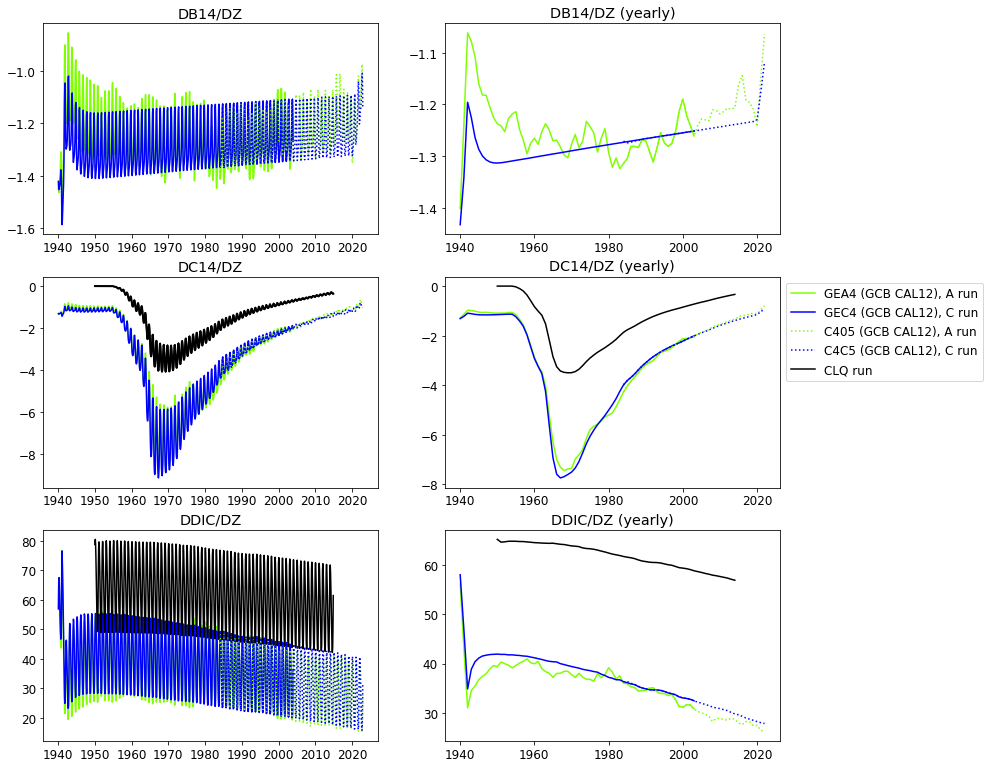

In [14]:
fact = 1.1
tf = 1e6
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

# C4C5_time = C4C5_dc14dz.indexes['time_counter'].to_datetimeindex()
# CLQ_time = CLQ_dc14dz.indexes['TIME_COUNTER']

times = GEA4_c.indexes['time_counter'].to_datetimeindex()
axs[0].plot(times, GEA4_c.DB14DZ, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.indexes['time_counter'].to_datetimeindex()
axs[0].plot(times, GEC4_c.DB14DZ, label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = C405_c.indexes['time_counter'].to_datetimeindex()
axs[0].plot(times, C405_c.DB14DZ, label = 'C405 (GCB CAL12), A run', color = 'chartreuse', linestyle = ':')
times = C4C5_c.indexes['time_counter'].to_datetimeindex()
axs[0].plot(times, C4C5_c.DB14DZ, label = 'C4C5 (GCB CAL12), C run', color = 'b', linestyle = ':')

times = GEA4_c.indexes['time_counter'].to_datetimeindex()
axs[2].plot(times, GEA4_c.DC14DZ, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.indexes['time_counter'].to_datetimeindex()
axs[2].plot(times, GEC4_c.DC14DZ, label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = C405_c.indexes['time_counter'].to_datetimeindex()
axs[2].plot(times, C405_c.DC14DZ, label = 'C405 (GCB CAL12), A run', color = 'chartreuse', linestyle = ':')
times = C4C5_c.indexes['time_counter'].to_datetimeindex()
axs[2].plot(times, C4C5_c.DC14DZ, label = 'C4C5 (GCB CAL12), C run', color = 'b', linestyle = ':')

axs[2].plot(CLQ_dc14dz.TIME_COUNTER,CLQ_dc14dz.DC14DZ, color = 'k', linewidth = 2)

times = GEA4_c.indexes['time_counter'].to_datetimeindex()
axs[4].plot(times, GEA4_c.DDICDZ*tf, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.indexes['time_counter'].to_datetimeindex()
axs[4].plot(times, GEC4_c.DDICDZ*tf, label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = C405_c.indexes['time_counter'].to_datetimeindex()
axs[4].plot(times, C405_c.DDICDZ*tf, label = 'C405 (GCB CAL12), A run', color = 'chartreuse', linestyle = ':')
times = C4C5_c.indexes['time_counter'].to_datetimeindex()
axs[4].plot(times, C4C5_c.DDICDZ*tf, label = 'C4C5 (GCB CAL12), C run', color = 'b', linestyle = ':')
axs[4].plot(CLQ_dc14dz.TIME_COUNTER,\
            CLQ_dc14dz.DDICDZ*tf, color = 'k', label = 'CLQ,run')
###

times = GEA4_c.time_counter.groupby('time_counter.year').mean().year
axs[0+1].plot(times, GEA4_c.DB14DZ.groupby('time_counter.year').mean(), label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.time_counter.groupby('time_counter.year').mean().year
axs[0+1].plot(times, GEC4_c.DB14DZ.groupby('time_counter.year').mean(), label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = C405_c.time_counter.groupby('time_counter.year').mean().year
axs[0+1].plot(times, C405_c.DB14DZ.groupby('time_counter.year').mean(), label = 'C405 (GCB CAL12), A run',\
              color = 'chartreuse', linestyle = ':')
times = C4C5_c.time_counter.groupby('time_counter.year').mean().year
axs[0+1].plot(times, C4C5_c.DB14DZ.groupby('time_counter.year').mean(), label = 'C4C5 (GCB CAL12), C run',\
              color = 'b', linestyle = ':')

axs[2].plot(CLQ_dc14dz.TIME_COUNTER,\
            CLQ_dc14dz.DC14DZ, color = 'k', label = 'CLQ,run')


times = GEA4_c.time_counter.groupby('time_counter.year').mean().year
axs[2+1].plot(times, GEA4_c.DC14DZ.groupby('time_counter.year').mean(), label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.time_counter.groupby('time_counter.year').mean().year
axs[2+1].plot(times, GEC4_c.DC14DZ.groupby('time_counter.year').mean(), label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = C405_c.time_counter.groupby('time_counter.year').mean().year
axs[2+1].plot(times, C405_c.DC14DZ.groupby('time_counter.year').mean(), label = 'C405 (GCB CAL12), A run',\
              color = 'chartreuse', linestyle = ':')
times = C4C5_c.time_counter.groupby('time_counter.year').mean().year
axs[2+1].plot(times, C4C5_c.DC14DZ.groupby('time_counter.year').mean(), label = 'C4C5 (GCB CAL12), C run',\
              color = 'b', linestyle = ':')
axs[2+1].plot(CLQ_dc14dz.TIME_COUNTER.groupby('TIME_COUNTER.year').mean().year,\
            CLQ_dc14dz.DC14DZ.groupby('TIME_COUNTER.year').mean(), color = 'k', label = 'CLQ run')



times = GEA4_c.time_counter.groupby('time_counter.year').mean().year
axs[4+1].plot(times, GEA4_c.DDICDZ.groupby('time_counter.year').mean()*tf, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.time_counter.groupby('time_counter.year').mean().year
axs[4+1].plot(times, GEC4_c.DDICDZ.groupby('time_counter.year').mean()*tf, label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = C405_c.time_counter.groupby('time_counter.year').mean().year
axs[4+1].plot(times, C405_c.DDICDZ.groupby('time_counter.year').mean()*tf, label = 'C405 (GCB CAL12), A run',\
              color = 'chartreuse', linestyle = ':')
times = C4C5_c.time_counter.groupby('time_counter.year').mean().year
axs[4+1].plot(times, C4C5_c.DDICDZ.groupby('time_counter.year').mean()*tf, label = 'C4C5 (GCB CAL12), C run',\
              color = 'b', linestyle = ':')

axs[4+1].plot(CLQ_dc14dz.TIME_COUNTER.groupby('TIME_COUNTER.year').mean().year,\
            CLQ_dc14dz.DDICDZ.groupby('TIME_COUNTER.year').mean()*tf, color = 'k', label = 'CLQ run')


axs[3].legend(bbox_to_anchor = [1,1])
tits = ['DB14/DZ','DB14/DZ (yearly)','DC14/DZ','DC14/DZ (yearly)',\
       'DDIC/DZ','DDIC/DZ (yearly)']
for i in range(0,6):
    axs[i].set_title(tits[i])

In [9]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/ModelResources/RestartFiles/restart_19191231_opa_obs_v3.6_ncep.nc')

w.time_counter

<xarray.DataArray 'time_counter' (t: 1)>
array([5475.])
Dimensions without coordinates: t

## what is the b14 and c14 atmospheric conc? c14 is 0. 

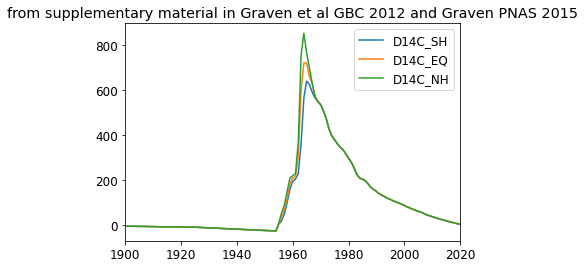

In [15]:
atmc14 = './c14dat/atmc14_mod.dat'
atmb14 = './c14dat/atmb14_mod.dat'

dfb14 = pd.read_csv(atmb14, delimiter=',')
dfc14 = pd.read_csv(atmc14, delimiter=',')
#
plt.figure()
plt.plot(dfb14['YEAR'],dfb14['D14C_SH'], label = 'D14C_SH')
plt.plot(dfb14['YEAR'],dfb14['D14C_EQ'], label = 'D14C_EQ')
plt.plot(dfb14['YEAR'],dfb14['D14C_NH'], label = 'D14C_NH')
plt.xlim([1900,2020])
plt.title('from supplementary material in Graven et al GBC 2012 and Graven PNAS 2015')
plt.legend()

## c14 and b14 variables

-11.886084
1.4079049


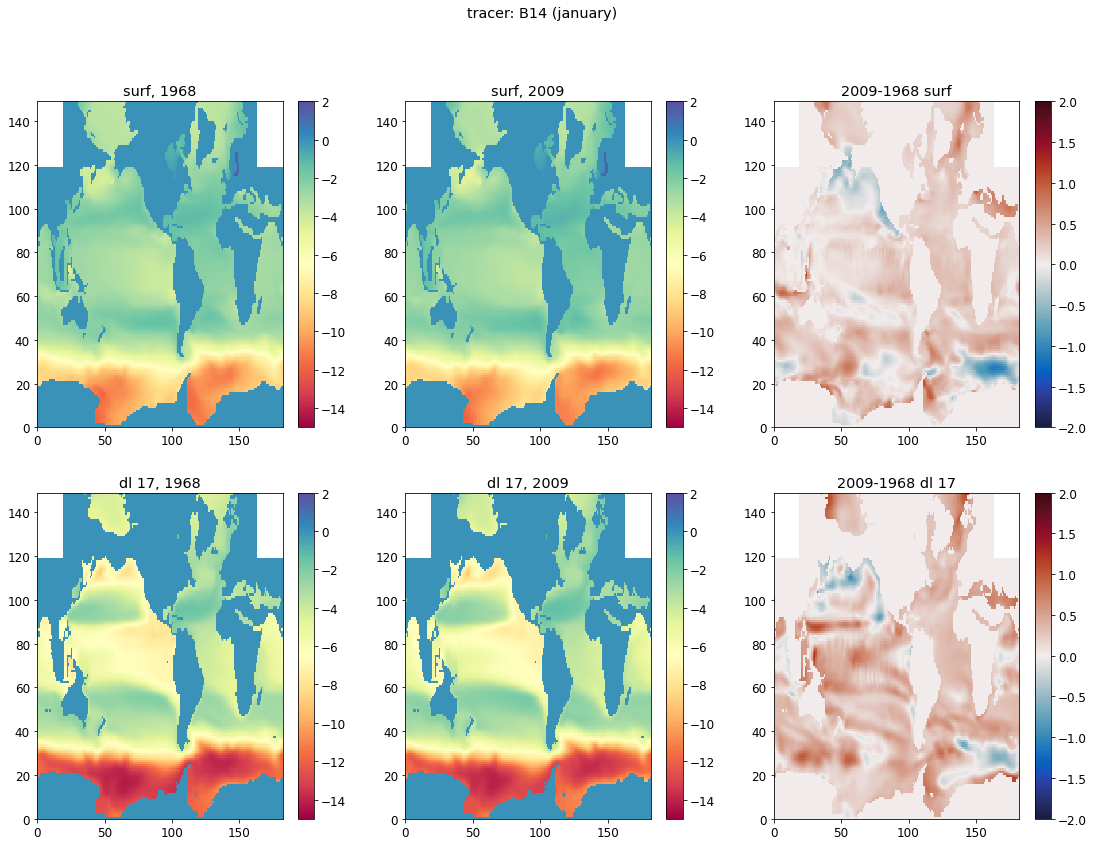

In [32]:
tdir = '/gpfs/afm/greenocean/software/runs/TOM12_TJ_GEA4/'
f1 = xr.open_dataset(f'{tdir}/ORCA2_1m_19680101_19681231_ptrc_T.nc')
f2 = xr.open_dataset(f'{tdir}/ORCA2_1m_20090101_20091231_ptrc_T.nc')


fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(17*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tmin = -15; tmax = 2

print(np.nanmin(f1.B14B[0,0,:,:]))
print(np.nanmax(f1.B14B[0,0,:,:]))
w = axs[0].pcolormesh(f1.B14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[0])
w = axs[3].pcolormesh(f1.B14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[3])

w = axs[1].pcolormesh(f2.B14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[1])
w = axs[4].pcolormesh(f2.B14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[4])


w = axs[2].pcolormesh(f2.B14B[0,0,:,:]-f1.B14B[0,0,:,:], cmap = cm.balance, vmin = -2, vmax = 2)
plt.colorbar(w, ax = axs[2])
w = axs[5].pcolormesh(f2.B14B[0,17,:,:]-f1.B14B[0,17,:,:], cmap = cm.balance, vmin = -2, vmax = 2)
plt.colorbar(w, ax = axs[5])

plt.suptitle('tracer: B14 (january)')
tits = ['surf, 1968','surf, 2009', '2009-1968 surf',\
        'dl 17, 1968','dl 17, 2009', '2009-1968 dl 17',\
       ]
for i in range(0,6):
    
    axs[i].set_title(tits[i])

-9.748243
59.57702


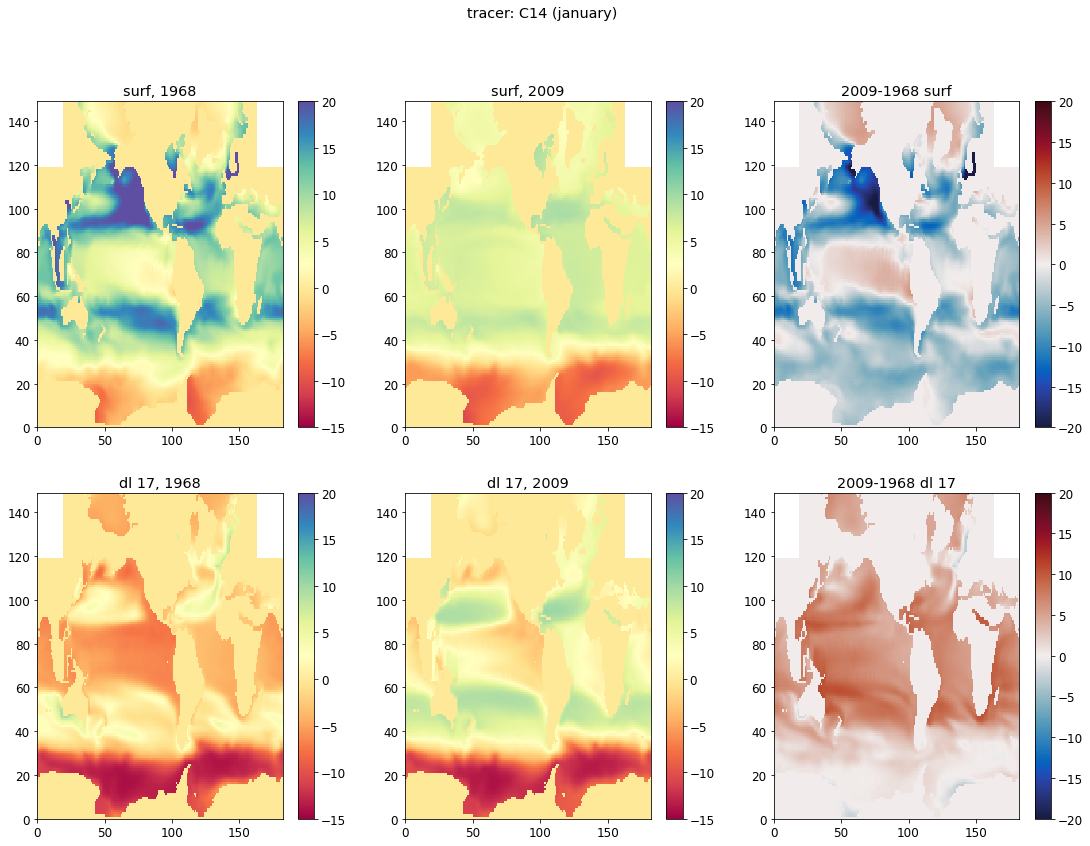

In [37]:
tdir = '/gpfs/afm/greenocean/software/runs/TOM12_TJ_GEA4/'
f1 = xr.open_dataset(f'{tdir}/ORCA2_1m_19680101_19681231_ptrc_T.nc')
f2 = xr.open_dataset(f'{tdir}/ORCA2_1m_20090101_20091231_ptrc_T.nc')


fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(17*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tmin = -15; tmax = 20

print(np.nanmin(f1.C14B[0,0,:,:]))
print(np.nanmax(f1.C14B[0,0,:,:]))
w = axs[0].pcolormesh(f1.C14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[0])
w = axs[3].pcolormesh(f1.C14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[3])

w = axs[1].pcolormesh(f2.C14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[1])
w = axs[4].pcolormesh(f2.C14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[4])


w = axs[2].pcolormesh(f2.C14B[0,0,:,:]-f1.C14B[0,0,:,:], cmap = cm.balance, vmin = -20, vmax = 20)
plt.colorbar(w, ax = axs[2])
w = axs[5].pcolormesh(f2.C14B[0,17,:,:]-f1.C14B[0,17,:,:], cmap = cm.balance, vmin = -20, vmax = 20)
plt.colorbar(w, ax = axs[5])

plt.suptitle('tracer: C14 (january)')
tits = ['surf, 1968','surf, 2009', '2009-1968 surf',\
        'dl 17, 1968','dl 17, 2009', '2009-1968 dl 17',\
       ]
for i in range(0,6):
    
    axs[i].set_title(tits[i])